# Text Image Super Resolution with OpenVINO

Super Resolution is the process of enhancing the quality of an image by increasing the pixel count using deep learning. This notebook shows the Text Image Super Resolution (TISR) which takes just one low resolution image with blured text, and output a high resolution image which have clear text. We use a model called [text-image-super-resolution-0001](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/text-image-super-resolution-0001/README.md) which is available from the Open Model Zoo.


## 1. Preparation

### First let's import the packages we need


In [1]:
import os
from pathlib import Path

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

import sys
sys.path.append("../utils")
from notebook_utils import load_image

### Set the device type, model path and model name


In [2]:
# Device to use for inference. For example, "CPU", or "GPU"
DEVICE = "CPU"
# Model file path and model name
MODEL_FILE = "model/text-image-super-resolution-0001.xml"
model_name = os.path.basename(MODEL_FILE)
model_xml_path = Path(MODEL_FILE).with_suffix(".xml")

print(f"Model name: {model_name}")
print(f"Model XML file path: {model_xml_path}")

Model name: text-image-super-resolution-0001.xml
Model XML file path: model\text-image-super-resolution-0001.xml


## 2. Load the Text Image Super Resolution Model

### After preparation, now we are going to load the model

The Text Image Super Resolution model expects one input: the input shape format as (B, C, H, W), B is batch-size, C is number of channels, H is image height, W is image width. By default the input shape is (1, 1, 360, 640).

Load the model in Inference Engine with ie.read_model, compile it for the specified device with ie.compile_model, and get information about the network inputs and outputs.


In [3]:
ie = Core()
model = ie.read_model(model=model_xml_path)
compiled_model = ie.compile_model(model=model, device_name=DEVICE)

input_layer_ir = next(iter(compiled_model.inputs))
output_layer_ir = next(iter(compiled_model.outputs))

# Get the expected input and target shape.
input_height, input_width = list(input_layer_ir.shape)[2:]
target_height, target_width = list(output_layer_ir.shape)[2:]

upsample_factor = int(target_height / input_height)

print(f"The network expects inputs with a width of {input_width}, " f"height of {input_height}")
print(f"The network returns images with a width of {target_width}, " f"height of {target_height}")

print(
    f"The image sides are upsampled by a factor {upsample_factor}. "
    f"The new image is {upsample_factor**2} times as large as the "
    "original image"
)

The network expects inputs with a width of 640, height of 360
The network returns images with a width of 1920, height of 1080
The image sides are upsampled by a factor 3. The new image is 9 times as large as the original image


## 3. Load Image And Prepare For Inference

Here we define some functions which will be used to convert image and visualization.
Then we load the source image, convert to gray scale and reshape it.


Source image shape: (220, 430, 3)
Gray scale image shape: (220, 430)
Gray scale image resized shape: (360, 640)
Input image shape: (1, 1, 360, 640)


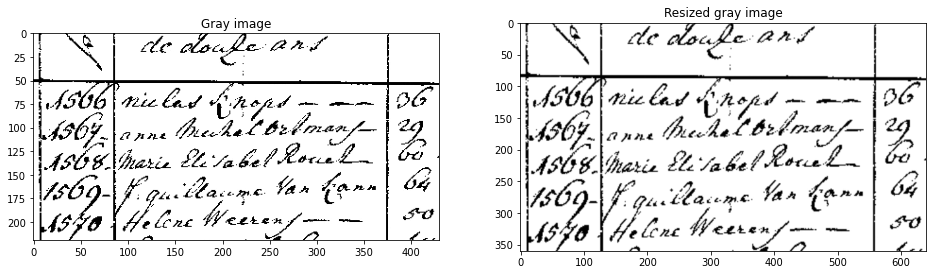

In [4]:
def bgr_to_gray(image: np.ndarray) -> np.ndarray:
    """
    Convert BGR image to Gray scale image
    
    :param image: an BGR image store as numpy array
    :return: gray scale image as numpy array
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def viz_result_image(
    result_image: np.ndarray,
    source_image: np.ndarray = None,
    result_title: str = None,
    source_title: str = None,
    result_gray_scale: bool = False,
    source_gray_scale: bool = False
) -> matplotlib.figure.Figure:
    """
    Show result image, optionally together with source images. Modify from notebook_utils.viz_result_image, add gray scale image support.

    :param result_image: Numpy array of result image.
    :param source_image: Numpy array of source image. If provided this image will be shown next to the result image.
    :param result_title: Title to display for the result image.
    :param source_title: Title to display for the source image.
    :param result_gray_scale: If true, matplotlib will plot the image in gray scale.
    :param source_gray_scale: If true, matplotlib will plot the image in gray scale.
    :return: Matplotlib figure with result image
    """
    num_images = 1 if source_image is None else 2
    fig, ax = plt.subplots(1, num_images, figsize=(16, 8), squeeze=False)
    if source_image is not None:
        ax[0, 0].imshow(source_image, cmap='gray' if source_gray_scale else None)
        ax[0, 0].set_title(source_title)
    ax[0, num_images - 1].imshow(result_image, cmap='gray' if result_gray_scale else None)
    ax[0, num_images - 1].set_title(result_title)
    plt.close(fig)
    return fig


def convert_result_to_image(result) -> np.ndarray:
    """
    Convert network result of floating point numbers to image with integer
    values from 0-255. Values outside this range are clipped to 0 and 255.

    :param result: a single superresolution network result in N,C,H,W shape
    """
    result = result.squeeze(0).transpose(1, 2, 0)
    result *= 255
    result[result < 0] = 0
    result[result > 255] = 255
    result = result.astype(np.uint8)
    return result


# Read source image
img = load_image("data/text.png")
# Convert source image to gray scale
gray_img = bgr_to_gray(img)

# Resize
resized_img = cv2.resize(gray_img, (input_width, input_height))

# Reshape to fit the model's input shape
input_img = np.expand_dims(resized_img, axis=0)
input_img = np.expand_dims(input_img, axis=0)

print(f"Source image shape: {img.shape}")
print(f"Gray scale image shape: {gray_img.shape}")
print(f"Gray scale image resized shape: {resized_img.shape}")
print(f"Input image shape: {input_img.shape}")
# View the source image and gray scale image
# viz_result_image(gray_img, img,
#                  source_title="Source image", result_title="Gray image",
#                  source_gray_scale=False, result_gray_scale=True)
# View the gray scale image and resized image
viz_result_image(resized_img, gray_img,
                 result_title="Resized gray image", source_title="Gray image",
                 result_gray_scale=True, source_gray_scale=True)


## 4. Do Inference And Plot The Result

### Do inference using compiled model, squeeze the shape and compare to source image

The model's output shape is (1, 1, 1080, 1920), we need to reduce the dimension.


Model's output shape: (1, 1, 1080, 1920)
Output image shape: (1080, 1920, 1)


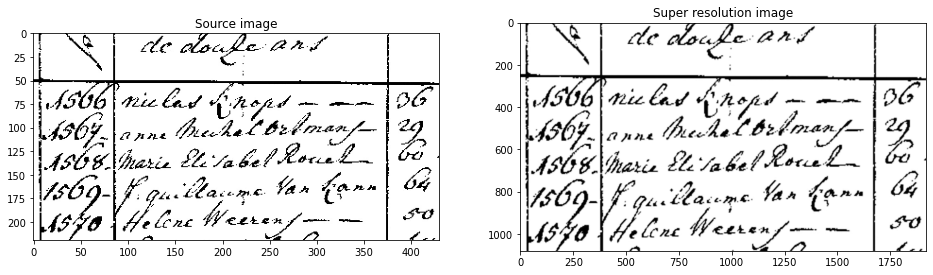

In [5]:
# Input data to the model and get result
result = compiled_model([input_img])[output_layer_ir]
# Reduce the dimension
superresolution_image = convert_result_to_image(result)
print(f"Model's output shape: {result.shape}")
print(f"Output image shape: {superresolution_image.shape}")

viz_result_image(superresolution_image, img,
                 result_title="Super resolution image", source_title="Source image",
                 result_gray_scale=True, source_gray_scale=False)

### Compare to bicubic image


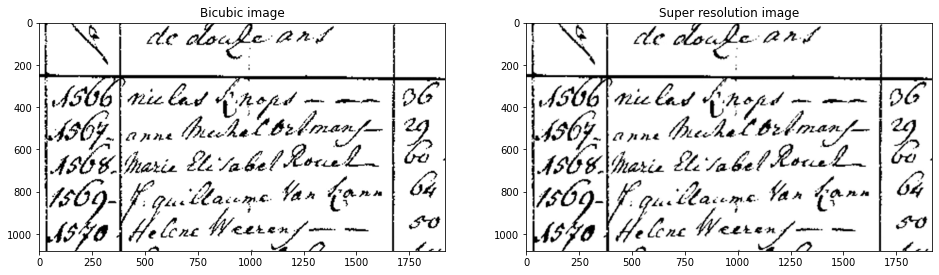

In [6]:
bicubic_image = cv2.resize(gray_img, (target_width, target_height), interpolation=cv2.INTER_CUBIC)

viz_result_image(superresolution_image, bicubic_image,
                 result_title="Super resolution image", source_title="Bicubic image",
                 result_gray_scale=True, source_gray_scale=True)


## 5. Save Output To File

Save the super resolution image and bicubic image to the output folder.


In [7]:
# Output path
OUTPUT_PATH = "output"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Save the images
cv2.imwrite(f"{OUTPUT_PATH}/superresolution_image.png", superresolution_image)
cv2.imwrite(f"{OUTPUT_PATH}/bicubic_image.png", bicubic_image)

True